# Bibliotecas

In [ ]:
# Importando bibliotecas necessárias para a analise e manipulação dos dados
import warnings
import numpy as np 
import pandas as pd 
import kagglehub
import os
import io

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
import plotly.io as pio
from scipy.ndimage import gaussian_filter1d


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import itertools
from IPython.display import FileLink, Image, display

import tensorflow as tf
from tensorflow.keras.models import load_model

# Configuração para mostrar gráficos do plotly no kaggle notebook
pio.renderers.default = 'notebook_connected' # Força renderizador padrão interativo

# Baixando o dataset State of Data Brazil 2025 diretamente do kaggle
path = kagglehub.dataset_download("datahackers/state-of-data-brazil-20242025")
filename = "/Final Dataset - State of Data 2024 - Kaggle - df_survey_2024.csv"
df = pd.read_csv(path + filename) # Concatenação entre o caminho geral e o nome do arquivo csv do dataset.


# Exploração dos Dados

In [ ]:
# Analisando as cunas presentes no dataset para insights.
df.columns

In [ ]:
# Função para Splitar o dataframe completo a partir do número do questionário desejado, e.g., 1,2,3, etc.
def split_df_by_questionary(dataframe: pd.DataFrame, questionary_num: int) -> pd.DataFrame:
    # Filtragem das colunas a partir da busca das colunas que começam com o número 'questionary_num'.
    filtered = dataframe.columns[dataframe.columns.str.startswith(str(questionary_num))]
    return dataframe[filtered] # Retorno da filtragem como um novo dataframe

In [ ]:
# Analisando se o split funcionou
df_splitted = split_df_by_questionary(dataframe=df, questionary_num=2)

# Ocultando warning para visualização dos dados incluindo valores NaN, -inf ou +inf
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(split_df_by_questionary(dataframe=df, questionary_num=2))

In [ ]:
# Splitando os questionários relevantes para a analise, e, armazenando-os em suas respectivas variavéis, e.g., q1 = questionário 1, etc.
q1 = split_df_by_questionary(dataframe=df, questionary_num=1).copy()
q2 = split_df_by_questionary(dataframe=df, questionary_num=2).copy()
q4 = split_df_by_questionary(dataframe=df, questionary_num=4).copy()

In [ ]:
# Checando o número de pessoas que estão Buscando novas oportunidades.
print(q2['2.n_planos_de_mudar_de_emprego_6m'].value_counts())

# Transformando para values e computando o percentual de pessoas que estão buscando um novo emprego x não estão procurando um novo emprego
num_looking4job = q2['2.n_planos_de_mudar_de_emprego_6m'].value_counts().values
looking4job = {"sim":round(num_looking4job[2:].sum()/sum(num_looking4job)*100, 2),
               "não":round(num_looking4job[0:2].sum()/sum(num_looking4job)*100,2)}

print(f"\nBuscando um novo emprego? \n{looking4job}")

In [ ]:
# Separando colunas interessantes para insights
working_status = q2['2.a_situação_de_trabalho'].dropna().copy()
working_exp = q2['2.i_tempo_de_experiencia_em_dados']
salary_range = q2['2.h_faixa_salarial']
hapiness = q2['2.k_satisfeito_atualmente']

work_type = q2['2.r_modelo_de_trabalho_atual'].dropna().copy()
work_type_ideal = q2['2.s_modelo_de_trabalho_ideal']

presencial_request = q2['2.t_atitude_em_caso_de_retorno_presencial']

Para simplificar a análise, agruparemos os modelos de trabalho em categorias mais sucintas e objetivas, classificando-os em três tipos: Presencial, Híbrido e Remoto, conforme as regras abaixo:

* Modelo 100% presencial ➞ Presencial

* Modelo 100% remoto ➞ Remoto

* Modelo híbrido flexível... ➞ Híbrido

* Modelo híbrido com dias fixos de trabalho presencial ➞ Híbrido

Além disso, para tornar mais clara a resposta à pergunta "O que faria em caso de retomada do trabalho presencial?", aplicaremos a seguinte categorização:

* "Vou procurar outra oportunidade no modelo híbrido ou remoto" ➞ 'Buscar oportunidade no modelo híbrido ou remoto'

* "Vou procurar outra oportunidade no modelo 100% remoto" ➞ 'Buscar oportunidade no modelo remoto'

* "Vou aceitar e retornar ao modelo 100% presencial" ➞ 'Aceitar formato presencial'

Essas mudanças visam tornar a leitura mais objetiva e clara, facilitando a visualização dos dados apresentados no gráfico de forma direta e formal.

In [ ]:
work_type_summary = work_type.replace({
    'Modelo 100% presencial': 'Presencial',
    'Modelo 100% remoto': 'Remoto',
    'Modelo híbrido flexível (o funcionário tem liberdade para escolher quando estar no escritório presencialmente)': 'Híbrido',
    'Modelo híbrido com dias fixos de trabalho presencial': 'Híbrido'
})

presencial_request_summary = presencial_request.replace({'Vou procurar outra oportunidade no modelo híbrido ou remoto': 'Buscar Oportunidade no Modelo Híbrido ou Remoto',
                                                        'Vou procurar outra oportunidade no modelo 100% remoto': 'Buscar Oportunidade no Modelo Remoto',
                                                        'Vou aceitar e retornar ao modelo 100% presencial': 'Aceitar Formato Presencial'})


working_status_summary = working_status.replace({'Empregado (CLT)': 'Trabalhando',
                                                  'Empreendedor ou Empregado (CNPJ)': 'Trabalhando',
                                                  'Servidor Público ': 'Trabalhando',
                                                 'Trabalho na área Acadêmica/Pesquisador ': 'Trabalhando',
                                                 'Servidor Público':'Trabalhando',
                                                 'Trabalho na área Acadêmica/Pesquisador': 'Trabalhando',
                                                 'Vivo no Brasil e trabalho remoto para empresa de fora do Brasil':'Trabalhando',
                                                 'Vivo fora do Brasil e trabalho para empresa de fora do Brasil':'Trabalhando',
                                                 'Freelancer':'Trabalhando',
                                                 'Estagiário':'Trabalhando',
                                                
                                                'Desempregado, buscando recolocação':'Desempregado',
                                                'Somente Estudante (graduação)':'Desempregado',
                                                 'Somente Estudante (pós-graduação)':'Desempregado',
                                                'Desempregado e não estou buscando recolocação': 'Desempregado'})

# Checando se as atribuições foram realizadas corretamente
working_status_summary.value_counts()

p_request_summary_grouped = presencial_request_summary.replace({'Aceitar Formato Presencial':"SIM",
                                                                'Buscar Oportunidade no Modelo Remoto':'NÃO', 
                                                                'Buscar Oportunidade no Modelo Híbrido ou Remoto':'NÃO',
                                                               })

# Cálculo da Probabilidade Condicional

Para obter uma métrica de avaliação da probabilidade de rejeição por parte de um profissional da área de tecnologia, iremos considerar tanto variáveis qualitativas (como região de residência, sexo, entre outras) quanto quantitativas (como idade).

Por exemplo, deseja-se calcular a probabilidade de um indivíduo rejeitar a proposta de retorno ao modelo presencial, dado que possui uma idade igual a I=x (com base nos dados do dataset).

Nesse caso, essa probabilidade dessa pessoa rejeitar (P(R)) o retorno ao trabalho presencial, dado que ela tem idade I=x, é expressa como:

$$
P(R \mid I = x) = \frac{P(R \cap I = x)}{P(I = x)} = \frac{\text{número de pessoas com idade } x \text{ que rejeitam o retorno}}{\text{número total de pessoas com idade } x}
$$


In [ ]:
def prob_rejeicao_condicional_por_idade(idade:int, df_idade:pd.DataFrame=q1, df_rejections:pd.Series=p_request_summary_grouped):
    x = idade
    idades_index = df_idade.loc[df_idade['1.a_idade'] == x].index  # Índices das pessoas cuja idade é exatamente x
    
    P_I = len(idades_index) / len(df_idade)  # Probabilidade P(I = x), ou seja, a chance de uma pessoa da amostra ter idade igual a x
    non_accepting_people = df_rejections.loc[df_rejections=='NÃO'].index # Pessoas que 'NÃO' aceitam retorno ao presencial
    accepting_people = df_rejections.loc[df_rejections=='SIM'].index     # Pessoas que 'SIM' aceitam retorno ao presencial

    intersection = set(idades_index).intersection(set(non_accepting_people)) # Pessoas que 'NÃO' aceitam retorno ao presencial E cuja idade é exatamente x
    
    # P(R ∩ I=x): Calcula a proporção de pessoas com idade I = x que também rejeitam o retorno presencial
    P_intersec = len(intersection) / len(q1)
    
    # P(R | I=x): Probabilidade condicional de rejeitar o retorno presencial dado que a pessoa tem idade x
    P_cond = P_intersec / P_I
    
    return P_cond




In [ ]:
def prob_condicional(x,
                     coluna_df: str,
                     df_total: pd.DataFrame=q1,
                     df_respostas: pd.Series=p_request_summary_grouped,
                     resposta_negativa: str = 'NÃO') -> float:
    """
    Calcula a probabilidade condicional P(R = resposta_negativa | coluna_df = x)
    
    Parâmetros:
    - x: valor da variável condicional (ex: idade, sexo, região...)
    - coluna_df: nome da coluna da variável (ex: 'idade', 'sexo')
    - df_total: DataFrame com todos os dados (contendo a coluna 'coluna_df')
    - df_respostas: Série com as respostas (index compatível com df_total)
    - resposta_negativa: valor da resposta considerada como "rejeição" (padrão: 'NÃO')
    
    Retorna:
    - Probabilidade condicional P(rejeição | coluna = x)
    """

    # Índices dos registros onde a coluna tem valor x
    indices_com_x = df_total[df_total[coluna_df] == x].index

    # P(X = x)
    P_x = len(indices_com_x) / len(df_total)

    # Índices das pessoas que deram a resposta negativa
    indices_rejeicao = df_respostas[df_respostas == resposta_negativa].index

    # Interseção dos dois grupos
    intersecao = set(indices_com_x).intersection(set(indices_rejeicao))

    # P(R ∩ X = x)
    P_intersec = len(intersecao) / len(df_total)

    # P(R | X = x)
    P_cond = P_intersec / P_x if P_x > 0 else 0

    return P_cond


# Funções para Plotagem

In [ ]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

def plot_radar_top_categorias(
    serie: pd.Series,
    top_n: int = 15,
    title: str = "Radar: Critérios de Escolha de Emprego",
    cor: str = 'skyblue'  
):
    # Mapeia categorias compostas
    mapeamento = {
        'Plano de carreira e oportunidades de crescimento profissional': ['Plano de carreira', 'Oportunidades de crescimento profissional'],
        'Oportunidade de aprendizado e trabalhar com referências na área': ['Oportunidade de aprendizado', 'Trabalhar com referências na área'],
        'Ambiente e clima de trabalho': ['Ambiente de trabalho', 'Clima de trabalho'],
        'Propósito do trabalho e da empresa': ['Propósito do trabalho', 'Propósito da empresa'],
        'Falta de segurança jurídica no Brasil e instabilidade politica e monetária.': ['Falta de segurança jurídica no Brasil', 'Instabilidade política e monetária']
    }

    def explode_mapeamento(x):
        return mapeamento.get(x, x)

    # Explode categorias compostas
    categorias = serie.dropna().str.split(',').explode().str.strip()
    categorias = categorias.apply(explode_mapeamento).explode().str.strip()

    # Conta frequências e seleciona top_n
    frequencias = categorias.value_counts().head(top_n)

    labels = list(frequencias.index)
    values = list(frequencias.values)

    # Fecha o polígono
    labels.append(labels[0])
    values.append(values[0])

    # Cria gráfico radar com Plotly
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=labels,
        fill='toself',
        name='Critérios',
        line=dict(color=cor),
        fillcolor=cor,
        opacity=0.5
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(visible=True, showticklabels=False, ticks=''),
        ),
        showlegend=False,
        title=title,
        title_x=0.03,
        width=800,  
    height=600   
    )

    fig.show(renderer='notebook_connected')

In [ ]:
def alluvial_plot_categorico(origem: pd.Series,
                             destino: pd.Series,
                             fig_width: int = 900,
                             fig_height: int = 900,
                             title: str = "Fluxo entre Regiões",
                             palette: str = "Dark2"):

    df = pd.DataFrame({
        'Região de Origem': origem.astype(str),
        'Região Atual': destino.astype(str)
    }).dropna()

    total_origem = origem.value_counts()

    df['Região de Origem Label'] = df['Região de Origem'].astype(str)

    def calc_permanencia(regiao):
        orig_indices = origem[origem == regiao].index
        destino_counts = destino.loc[orig_indices].value_counts()
        permanencia = destino_counts.get(regiao, 0)
        total_origem_regiao = total_origem.get(regiao, 1)
        ratio = permanencia / total_origem_regiao if total_origem_regiao != 0 else 0
        return ratio

    regioes = df['Região Atual'].unique()
    permanencia_labels = {
        regiao: f"{regiao} ({calc_permanencia(regiao)*100:.2f}%)"
        for regiao in regioes
    }
    df['Região Atual Label'] = df['Região Atual'].map(permanencia_labels)

    categorias_origem = sorted(set(df['Região de Origem Label']))
    cores = pc.qualitative.__dict__.get(palette, pc.qualitative.Dark2)
    color_map = {cat: cores[i % len(cores)] for i, cat in enumerate(categorias_origem)}
    color_indices = df['Região de Origem Label'].map(lambda x: categorias_origem.index(x))

    fig = px.parallel_categories(
        df,
        dimensions=['Região de Origem Label', 'Região Atual Label'],
        color=color_indices,
        color_continuous_scale=[color_map[cat] for cat in categorias_origem],
        labels={
            'Região de Origem Label': 'Região Anterior',
            'Região Atual Label': 'Região Atual (% permanência)'
        },
        width=fig_width,
        height=fig_height
    )

    fig.update_layout(
        title_text=title,
        title_x=0.03,
        coloraxis_showscale=False
    )

    try:
        # Tenta mostrar interativamente
        fig.show(renderer='notebook_connected')
    except Exception as e:
        print("Plotly interativo falhou, exibindo como imagem estática...")

        try:
            # Converte para imagem PNG e exibe
            img_bytes = pio.to_image(fig, format='png', width=fig_width, height=fig_height)
            display(Image(data=img_bytes))
        except Exception as e2:
            print("Falha também na conversão para imagem.")
            print("Erro:", e2)

In [ ]:
def stacked_bar_chart(stack_variable: pd.Series,
                      x_variable: pd.Series,
                      title: str,
                      x_label: str,
                      y_label: str,
                      legend: str,
                      x_order: list = None,
                      x_label_size: int = 13,
                      y_label_size: int = 13,
                      title_size: int = 13,
                      legend_tittle_size: int = 13,
                      legend_size: int = 12,
                      figsize: tuple = (12, 7),
                      color_map: str = 'Dark2',
                      dropna: bool = True,
                      show_trend: bool = False,
                      var_trend: str = None):

    df2plot = pd.DataFrame({
        'stack_variable': stack_variable,
        'x_variable': x_variable
    })

    if dropna:
        df2plot = df2plot.dropna()

    # Frequência absoluta e percentual
    count_df = pd.crosstab(df2plot['x_variable'], df2plot['stack_variable'])
    percent_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

    if x_order is not None:
        percent_df = percent_df.loc[x_order]

    fig, ax = plt.subplots(figsize=figsize)
    colors = plt.get_cmap(color_map).colors[:len(percent_df.columns)]
    bottom = pd.Series([0] * len(percent_df), index=percent_df.index)

    for color, column in zip(colors, percent_df.columns):
        ax.bar(percent_df.index, percent_df[column], bottom=bottom, label=column,
               color=color, edgecolor='black', linewidth=0.5)
        for i, (idx, val) in enumerate(percent_df[column].items()):
            if val > 3:
                ax.text(i, bottom[idx] + val / 2, f'{val:.1f}%', ha='center', va='center',
                        color='black', fontsize=10, fontweight='bold')
        bottom += percent_df[column]

    # Linha de tendência: proporção da categoria var_trend
    if show_trend and var_trend in percent_df.columns:
        trend_vals = percent_df[var_trend]
        ax.plot(percent_df.index, trend_vals.values, color='black', linestyle='--', marker='o',
                label=f'Tendência ({var_trend})')

    # Labels e grid
    ax.set_title(title, fontsize=title_size)
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(title=legend, bbox_to_anchor=(1.05, 1), loc='upper left',
              fontsize=legend_size, title_fontsize=legend_tittle_size)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()


In [ ]:
def scatter_with_polynomial_fit(data: pd.Series,
                                 deg: int = 1,
                                 title: str = '',
                                 x_label: str = '',
                                 y_label: str = '',
                                 legend: str = '',
                                 x_label_size: int = 13,
                                 y_label_size: int = 13,
                                 title_size: int = 13,
                                 legend_tittle_size: int = 13,
                                 legend_size: int = 12,
                                 figsize: tuple = (12, 7),
                                 color_map: str = 'Dark2',
                                 x_order: list = None):
    
    # Reordenamento se x_order fornecido
    if x_order is not None:
        try:
            data = data.loc[x_order]
        except KeyError as e:
            print("Algumas categorias de x_order não existem na Series.")
            print("Erro:", e)
            return

    x = data.index
    y = data.values

    # Verifica se x é numérico
    try:
        x_numeric = pd.to_numeric(x)
        is_categorical = False
    except:
        is_categorical = True

    if is_categorical:
        if x_order is not None:
            x_ticks = {i: label for i, label in enumerate(data.index)}
            x_num = list(x_ticks.keys())
        else:
            # Categórico sem ordem fornecida → usa LabelEncoder
            x_str = x.astype(str)
            encoder = LabelEncoder()
            x_num = encoder.fit_transform(x_str)
            x_ticks = {i: label for i, label in enumerate(encoder.classes_)}
    else:
        x_num = x
        x_ticks = None

    # Remover valores ausentes
    mask = ~(pd.isnull(x_num) | pd.isnull(y))
    x_clean = np.array(x_num)[mask]
    y_clean = np.array(y)[mask]

    # Iniciar figura
    plt.figure(figsize=figsize)
    plt.scatter(x_clean, y_clean, color='black', alpha=0.8, edgecolors='k', marker='s', s=13, label='Dados')

    # Adicionar curvas de regressão de grau 1 até deg
    x_vals = np.linspace(min(x_clean), max(x_clean), 500)
    for d in range(1, deg + 1):
        coefs = np.polyfit(x_clean, y_clean, deg=d)
        y_fit = np.polyval(coefs, x_clean)

        ss_res = np.sum((y_clean - y_fit) ** 2)
        ss_tot = np.sum((y_clean - np.mean(y_clean)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        y_vals = np.polyval(coefs, x_vals)
        plt.plot(x_vals, y_vals, label=fr'$P_{{{d}}}$ (R² = {r2:.2f})', linewidth=2)

    # Títulos e rótulos
    plt.title(title, fontsize=title_size, loc='left')
    plt.xlabel(x_label, fontsize=x_label_size)
    plt.ylabel(y_label, fontsize=y_label_size)
    plt.legend(title=legend, fontsize=legend_size, title_fontsize=legend_tittle_size)
    plt.grid(True, linestyle='--', alpha=0.4)

    if x_ticks:
        plt.xticks(ticks=list(x_ticks.keys()), labels=list(x_ticks.values()), rotation=45)

    plt.tight_layout()
    plt.show()


In [ ]:
def barplot_from_series(data: pd.Series,
                        title: str = '',
                        x_label: str = '',
                        y_label: str = '',
                        title_size: int = 12,
                        x_label_size: int = 12,
                        y_label_size: int = 12,
                        figsize: tuple = (10, 5),
                        color: str = 'royalblue',
                        color_sns: str | None = None, 
                        rotation: int = 45,
                        ascending: bool = False):
    
    # Ordenar por valor (opcional: remova se quiser manter a ordem original)
    data = data.sort_values(ascending=ascending)
    
    plt.figure(figsize=figsize)

    # Define as cores: usa paleta sns se color_sns informado, senão usa color único
    if color_sns is not None:
        cores = sns.color_palette(color_sns, n_colors=len(data))
    else:
        cores = color
    
    plt.bar(data.index, data.values, color=cores, edgecolor='black')
    
    # Rótulos e título
    plt.title(title, fontsize=title_size, loc='left')
    plt.xlabel(x_label, fontsize=x_label_size)
    plt.ylabel(y_label, fontsize=y_label_size)
    
    plt.xticks(rotation=rotation, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_brazil_region_heatmap(data: pd.Series,
                                cmap: str = 'OrRd',
                                title: str = 'Mapa de Calor por Região',
                                figsize: tuple = (10, 8),
                                edgecolor: str = 'black',
                                linewidth: float = 0.8,
                                title_size: int = 15,
                                legend_label: str = 'Prob. Rejeição',
                                text_color: str = 'black',
                                text_size: int = 10):

    # Padronizar nomes de regiões no index
    data.index = data.index.str.title().str.replace("-", "–").str.replace("Centro–Oeste", "Centro-Oeste")

    # Mapeamento de siglas para regiões
    estados_para_regiao = {
        'AC': 'Norte', 'AM': 'Norte', 'AP': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
        'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste', 'PE': 'Nordeste',
        'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
        'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
        'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
        'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
    }

    # Baixa shapefile de estados
    estados = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson')

    estados['region'] = estados['sigla'].map(estados_para_regiao)

    # Dissolver geometria por região
    regioes = estados.dissolve(by='region')

    # Adiciona coluna com valores do `data`
    regioes['value'] = regioes.index.map(data)

    # Plotar o mapa
    ax = regioes.plot(column='value',
                      cmap=cmap,
                      edgecolor=edgecolor,
                      linewidth=linewidth,
                      figsize=figsize,
                      legend=True,
                      legend_kwds={'label': legend_label, 'shrink': 0.6})

    # Título
    ax.set_title(title, fontsize=title_size, loc='left')
    ax.axis('off')

    # Adicionar nomes das regiões
    for idx, row in regioes.iterrows():
        centroid = row['geometry'].centroid
        plt.text(centroid.x, centroid.y, idx, color=text_color,
                 fontsize=text_size, fontweight='bold', ha='center')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_idade_distribution(dataframe, coluna_idade, title='Figura 10: Distribuição das Idades dos Entrevistados',
                            cor_regiao='red', delta=0):
    """
    Plota histograma das idades com destaque automático da faixa de maior frequência.

    Parâmetros:
    - dataframe: DataFrame contendo os dados
    - coluna_idade: nome da coluna com as idades
    - title: título do gráfico
    - cor_regiao: cor da faixa destacada
    - delta: número de bins adicionais a incluir (ex: delta=1 expande para 1 bin à esquerda e direita)
    """
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Dados
    idades = dataframe[coluna_idade].dropna()

    # Estatísticas
    media = idades.mean()
    mediana = idades.median()
    moda = idades.mode().iloc[0]

    # Histograma para obter os bins e contagens
    counts, bins = np.histogram(idades, bins=20)
    max_bin_idx = np.argmax(counts)

    # Cálculo do novo intervalo com delta
    bin_width = bins[1] - bins[0]
    start_idx = max(0, max_bin_idx - delta)
    end_idx = min(len(bins) - 1, max_bin_idx + 1 + delta)

    bin_start = bins[start_idx]
    bin_end = bins[end_idx]

    # Plot
    plt.figure(figsize=(10, 5))
    sns.histplot(idades, bins=bins, kde=False, color='gray', edgecolor='black')

    # Região com maior frequência (expandida por delta)
    plt.axvspan(bin_start, bin_end, color=cor_regiao, alpha=0.2, label='Faixa de Maior Frequência')
    plt.axvline(bin_start, color=cor_regiao, linestyle='--', linewidth=1.5)
    plt.axvline(bin_end, color=cor_regiao, linestyle='--', linewidth=1.5)

    # Linhas verticais
    plt.axvline(media, color='black', linestyle=(0, (3,5,1,5,1,5)), linewidth=2, label=f'Média: {media:.1f}')
    plt.axvline(mediana, color='green', linestyle=(0,(3,10,1,10,1,10)), linewidth=2, label=f'Mediana: {mediana:.1f}')
    plt.axvline(moda, color='purple', linestyle=(0, (3,5,1,5)), linewidth=2, label=f'Moda: {moda:.0f}')

    # Título e rótulos
    plt.title(title, loc='left', fontsize=12)
    plt.xlabel('Idade [anos]')
    plt.ylabel('Frequência')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.xticks(np.arange(15, 70, 5))
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_idade_stack_nivel(q1, q2, title:str, destaque='Júnior', palette='Set2', figsize=(15, 6), 
                           range_destacado=None, cor_regiao='red'):

    # Combinar os dados
    df = pd.DataFrame({
        'idade': q1['1.a_idade'],
        'nivel': q2['2.g_nivel']
    }).dropna()

    # Agrupamento e normalização
    contagem = df.groupby(['idade', 'nivel']).size().unstack(fill_value=0)
    proporcao = contagem.div(contagem.sum(axis=1), axis=0).sort_index()
    idades = proporcao.index

    # Plot do histograma empilhado
    ax = proporcao.plot(kind='bar', 
                        stacked=True, 
                        color=sns.color_palette(palette, n_colors=len(proporcao.columns)),
                        edgecolor='black', 
                        width=0.9,
                        figsize=figsize)

    # Linha de tendência do nível destacado
    if destaque in proporcao.columns:
        y = proporcao[destaque].values
        y_smooth = gaussian_filter1d(y, sigma=1.5)
        ax.plot(range(len(idades)), y_smooth, color='black', linewidth=2.2, linestyle='--', label=f'Tendência {destaque}')

    # Região destacada (janela de análise)
    if range_destacado is not None:
        ini, fim = range_destacado

        idade_idx = list(idades)
        pos_ini = idade_idx.index(ini) if ini in idade_idx else None
        pos_fim = idade_idx.index(fim) if fim in idade_idx else None

        if pos_ini is not None and pos_fim is not None:
            ax.axvspan(pos_ini - 0.5, pos_fim + 0.5, color=cor_regiao, alpha=0.2, label='Região de Análise')
            ax.axvline(pos_ini - 0.5, color=cor_regiao, linestyle='--', linewidth=1.5)
            ax.axvline(pos_fim + 0.5, color=cor_regiao, linestyle='--', linewidth=1.5)

    # Estética do gráfico
    ax.set_title(title, loc='left', fontsize=14)
    ax.set_xlabel('Idade [anos]')
    ax.set_ylabel('Proporção (%)')
    ax.set_xticks(range(len(idades)))
    ax.set_xticklabels(idades, rotation=30)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.legend(title='Nível')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_ai_training_results(results_df, x_def='Features', title_num=13):
    if x_def not in ['Features', 'Epoch']:
        raise ValueError("x_def deve ser 'Features' ou 'Epoch'")

    x_col = 'n_features' if x_def == 'Features' else 'epoch'
    x_label = 'Número de Features' if x_def == 'Features' else 'Época'

    learning_rates = sorted(results_df['learning_rate'].unique())

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot de acurácia
    for lr in learning_rates:
        subset = results_df[results_df['learning_rate'] == lr]
        ax1.plot(subset[x_col], subset['val_accuracy'], marker='o', label=f'Taxa de Aprendizado = {lr}')
    ax1.set_ylabel('Acurácia')
    ax1.set_title(f'Figura {title_num}: Acurácia por {x_label}', loc='left', fontsize=12)
    ax1.grid(True)
    ax1.legend()

    # Plot de loss
    for lr in learning_rates:
        subset = results_df[results_df['learning_rate'] == lr]
        ax2.plot(subset[x_col], subset['val_loss'], marker='s', linestyle='--', label=f'Taxa de Aprendizado = {lr}')
        
    ax2.set_xlabel(x_label)
    ax2.set_ylabel('Validação Loss')
    ax2.set_title(f'Figura {title_num+1}: Validação Loss por {x_label}', loc='left', fontsize=12)
    ax2.grid(True)
    ax2.legend()

    # Forçar xticks inteiros no eixo compartilhado
    ticks = np.arange(results_df[x_col].min(), results_df[x_col].max() + 1, 1)
    ax2.set_xticks(ticks)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_confusion_matrix(model, dataframe, features, y_class_to_index, y_classes, percent=False):
    # Preparar dados
    X = dataframe[features].copy()
    y_true = dataframe['classe'].values  # já é 0 ou 1

    # One-hot encoding para features (igual no treinamento)
    X_encoded = pd.get_dummies(X, columns=[col for col in features if col != 'idade'])
    X_encoded = X_encoded.astype(np.float32)

    # Predição do modelo (probabilidades)
    y_pred_proba = model.predict(X_encoded.values)

    # Como é binário (sigmoid), converte com threshold de 0.5
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Calcular matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # Se for para mostrar em percentual
    if percent:
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        # Plot manual com valores percentuais
        fig, ax = plt.subplots()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nao Aceita', 'Aceita'])
        disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.1f')
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, f"{cm_percent[i, j]:.1f}%", ha="center", va="center", color="black", fontsize=12)
        plt.title("Matriz de Confusão (% por linha)")
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nao Aceita', 'Aceita'])
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title("Matriz de Confusão (valores absolutos)")

    plt.show()

In [ ]:
def plot_confusion_matrix(model, dataframe, features, y_class_to_index, y_classes, percent=False, figsize=(10, 6), title="Matriz de Confusão"):
    # Preparar dados
    X = dataframe[features].copy()
    y_true = dataframe['classe'].values  # já é 0 ou 1

    # One-hot encoding para features (igual no treinamento)
    X_encoded = pd.get_dummies(X, columns=[col for col in features if col != 'idade'])
    X_encoded = X_encoded.astype(np.float32)

    # Predição do modelo (probabilidades)
    y_pred_proba = model.predict(X_encoded.values)

    # Para classificação binária com sigmoid
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Calcular matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # Se quiser em porcentagem
    if percent:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = ".2%"  # formato percentual
    else:
        fmt = "d"  # formato inteiro

    labels = ['Não Aceita', 'Aceita']

    # Criar figura e eixo com figsize
    fig, ax = plt.subplots(figsize=figsize)

    # Plotar matriz
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=fmt, colorbar=False)

    # Ajustar título à esquerda
    ax.set_title(title, loc='left', fontsize=14)

    # Definir rótulos dos eixos em português
    ax.set_xlabel("Rótulo Previsto", fontsize=12)
    ax.set_ylabel("Rótulo Correto", fontsize=12)

    # Tamanho dos ticks
    ax.tick_params(axis='both', labelsize=10)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_accuracy_errors(model, subset_df, features, title:str, threshold=0.5, figsize:tuple=(10,6)):
    # Preparar dados
    X = subset_df[features].copy()
    y_true = subset_df['classe'].values

    # One-hot encoding igual treino
    X_encoded = pd.get_dummies(X, columns=[col for col in features if col != 'idade'])
    X_encoded = X_encoded.astype(np.float32)

    # Predição
    y_pred_proba = model.predict(X_encoded.values)
    y_pred = (y_pred_proba > threshold).astype(int).flatten()

    # Contar acertos e erros
    acertos = np.sum(y_pred == y_true)
    erros = np.sum(y_pred != y_true)
    total = acertos + erros

    # Converter para porcentagem
    acertos_pct = acertos / total * 100
    erros_pct = erros / total * 100

    # Cores do cmap Pastel2
    colors = plt.get_cmap('Pastel2')(np.linspace(0, 1, 2))

    # Plotar barras
    plt.figure(figsize=figsize)
    bars = plt.bar(['Taxa de Acerto', 'Taxa de Erro'], [acertos_pct, erros_pct], color=colors)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, loc='left', fontsize=12)
    plt.ylabel('Porcentagem (%)', fontsize=12)

    # Adicionar grid tracejado somente no eixo y
    plt.grid(True, linestyle='--', axis='y')

    # Mostrar os valores percentuais em cima das barras
    for bar, pct in zip(bars, [acertos_pct, erros_pct]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{pct:.2f}%', 
                 ha='center', va='bottom', fontsize=12)

    plt.ylim(0, 110)
    plt.show()

In [ ]:
def evaluate_model(model, dataframe, features, y_class_to_index, y_classes):
    """
    Avalia o modelo no conjunto de teste e retorna métricas detalhadas.
    """

    # Preparar dados
    X = dataframe[features].copy()
    y_true = dataframe['classe'].map(y_class_to_index).values

    # One-hot encoding para features (igual ao usado no treinamento)
    X_encoded = pd.get_dummies(X, columns=[col for col in features if col != 'idade'])
    X_encoded = X_encoded.astype(np.float32)

    # Predição (saída é probabilidade com sigmoid)
    y_pred_proba = model.predict(X_encoded.values)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Labels legíveis para o relatório
    target_names = ['Nao Aceita', 'Aceita']

    # Relatório completo
    report = classification_report(
        y_true, y_pred,
        target_names=target_names,
        digits=4,
        output_dict=True
    )

    acc = accuracy_score(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

    return report, acc

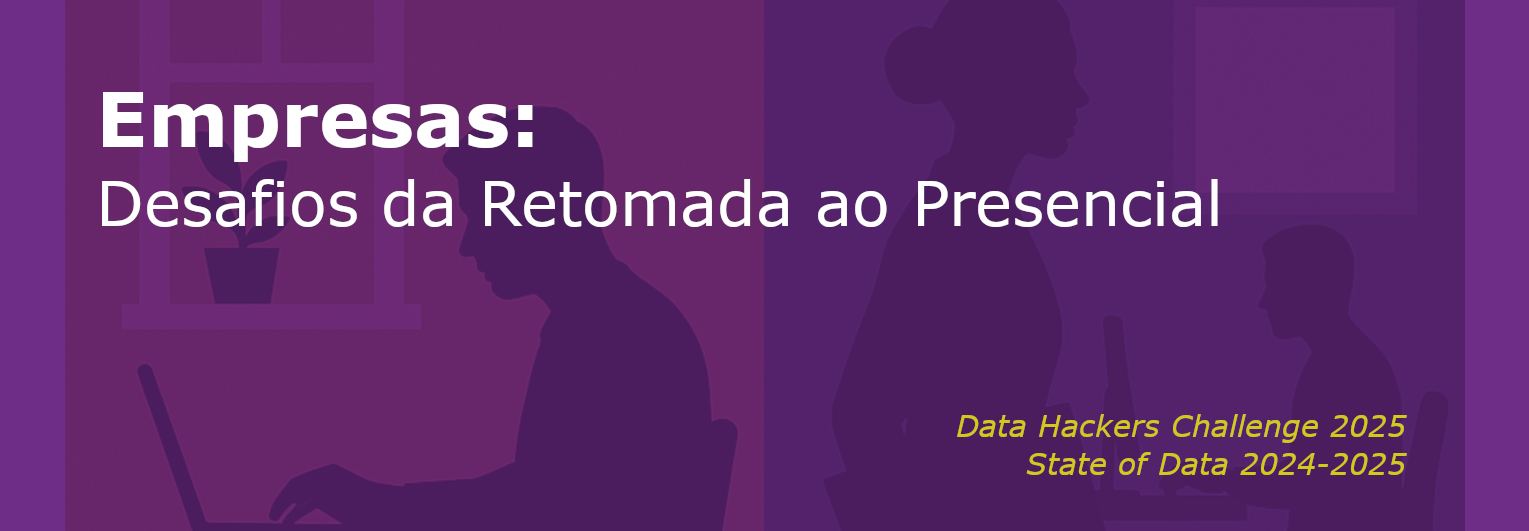

# Introdução

O mundo atual é marcado por dinâmicas cada vez mais complexas e aceleradas. Durante décadas, o trabalho presencial foi amplamente adotado como padrão nas relações laborais, sendo considerado pelas empresas a fórmula ideal de eficiência e controle produtivo. No entanto, a pandemia de Covid-19 impôs uma ruptura abrupta a esse modelo. Com os lockdowns e as restrições sanitárias globais, organizações de diversos setores foram forçadas a adotar soluções alternativas, como o trabalho remoto e modelos híbridos, flexibilizando estruturas que antes pareciam inquestionáveis.

À medida que o cenário sanitário começou a se estabilizar com o avanço da vacinação, emergiu uma nova fase de decisões organizacionais: a de como (e se) retornar ao modelo anterior. Nesse contexto, muitas empresas — especialmente as de perfil mais tradicional — optaram por retomar rapidamente o trabalho 100% presencial. Esse movimento foi motivado, em parte, por um ceticismo enraizado entre líderes empresariais: “81% dos empregadores estão céticos quanto à produtividade no trabalho remoto, enquanto 77% dos funcionários acreditam que a volta ao escritório é mais uma questão de aparência do que de resultados”. Ainda assim, paradoxalmente, muitas dessas mesmas empresas relataram um aumento de até 19% na produtividade e no engajamento dos colaboradores após o retorno presencial [[4](#ref-4)].

Nesse contexto, este relatório busca explorar como a exigência pela retomada do modelo presencial tem impactado a percepção dos trabalhadores, bem como os principais desafios enfrentados pelas organizações nesse processo de adaptação pós-pandemia. Além disso, o relatório tem como foco avaliar as tendências e preferências da nova geração que comporá o mercado de trabalho nos próximos anos, desenvolvendo um modelo de classificação capaz de prever se um usuário com determinado perfil tende a preferir o formato presencial (*seção Modelo de Classificação (IA)*).

Essa ferramenta poderá servir como uma solução para a avaliação de candidatos, sendo utilizada em processos seletivos por empresas que buscam identificar profissionais dispostos a atuar presencialmente, considerando seu perfil e modo de trabalho atual — seja remoto, híbrido ou presencial.

Para tanto, o relatório se baseia na análise dos dados do dataset “State of Data Brazil 2024-2025”, que visa mapear o mercado de trabalho da área de dados no Brasil, refletindo o perfil dos profissionais — como analistas, cientistas e engenheiros de dados —, suas preferências e valores no âmbito corporativo.

# Desenvolvimento e Análise Estatística

## Status e Modelo de Trabalho
Com base na [`Figura 1`](#figura-1), observa-se que profissionais já inseridos em modalidades de trabalho flexíveis, como o modelo híbrido ou totalmente remoto, demonstram uma inclinação significativa em permanecer nesses formatos.

No caso específico dos que atuam em regime híbrido, destaca-se que mais de 70% não estão dispostos a retornar ao modelo 100% presencial — evidenciado, inclusive, pelos 10.7% que manifestam intenção de buscar novas oportunidades exclusivamente remotas.

De maneira ainda mais acentuada, profissionais em regime remoto apresentam baixíssima predisposição ao retorno presencial, com apenas 8.7% sinalizando essa possibilidade.

Diante desses dados, é possível inferir que apenas os profissionais já atuantes em regime presencial — e que, portanto, já possuem familiaridade e possível preferência por esse formato — demonstram uma intenção clara de permanecer nesse modelo de trabalho.


<a id="figura-1"></a>

In [ ]:
# Figura 1
stacked_bar_chart(stack_variable=presencial_request_summary, x_variable=work_type_summary, 
                  x_order = ['Presencial', 'Híbrido', 'Remoto'],
                 title='Figura 1: Taxa de aceite ao retorno presencial.', 
                  x_label='Modelo de Trabalho Atual', y_label='Porcentagem [%]', 
                  legend='Decisão', 
                 show_trend=True, var_trend='Aceitar Formato Presencial',
                 figsize=(10,5))


Além disso, conforme evidenciado na [`Figura 2`](#figura-2), o fato de a pessoa estar empregada ou não, impacta diretamente nas chances de recusa ao retorno presencial. 

Isso porque, como mostra a figura, profissionais atualmente empregados demonstram maior resistência ao retorno obrigatório, o que sugere que a estabilidade no emprego lhes confere maior poder de escolha quanto ao formato de trabalho desejado.

<a id="figura-2"></a>

In [ ]:
# Figura 2
stacked_bar_chart(stack_variable=p_request_summary_grouped, 
                  x_variable=working_status_summary, 
                  title='Figura 2: Retorno ao Presencial x Status Atual de Trabalho.', 
                  x_order=['Prefiro não informar', 'Desempregado', 'Trabalhando',], 
                  x_label='Status de Trabalho Atual', y_label='Porcentagem [%]',
                  show_trend=True, var_trend='NÃO',
                  legend='Aceitar retorno ao presencial integral',
                 figsize=(10,5))

Nota-se que, independentemente de a pessoa estar trabalhando ou desempregada, em ambos os casos a probabilidade de aceitar uma mudança para o trabalho presencial integral é claramente baixa em comparação com a rejeição dessa adoção. 

Mesmo entre as pessoas que optaram por não informar seu status profissional, ainda é possível observar esse padrão comportamental consistente.

## Setor de Atuação

Para investigar se o setor de atuação exerce influência sobre a aceitação do retorno ao trabalho presencial integral, analisou-se a probabilidade de rejeição condicional ao setor de atuação (P[Rejeição | Setor]) para cada segmento presente no conjunto de dados.

Os resultados, conforme indicado na [`Figura 3`](#figura-3), demonstram que o setor de atuação influencia significativamente essa probabilidade. Setores tradicionalmente associados à tecnologia, como Tecnologia/Fábrica de Software, Internet/Ecommerce e Telecomunicação, apresentam as maiores taxas de rejeição. Em contraste, setores como o Setor Público, Agronegócio e Construção Civil demonstram menor resistência ao retorno presencial, indicando maior disposição dos profissionais desses segmentos em adotar esse modelo.


<a id="figura-3"></a>

In [ ]:
setores = q2['2.b_setor'].value_counts().index

probs_setor = pd.Series(
    [prob_condicional(x=setor, coluna_df='2.b_setor', df_total=q2) for setor in setores],
    index=setores,
    name='P(Rejeição | Setor)'
)


# Figura 3
barplot_from_series(
    data=probs_setor*100,
    title='Figura 3: O setor de atuação influencia na probabilidade de rejeição?',
    x_label='Setor',
    y_label='Probabilidade de Rejeição [%]',
    color='mediumpurple'
)

Esse fator pode ser validado, haja vista que 57% dos servidores públicos federais preferiram voltar ao trabalho presencial após o lockdown obrigatório [[4](#ref-4)]. Além disso, setores como o agronegócio e a construção civil desempenharam um papel de grande relevância durante o período da pandemia em 2020, tendo, em alguns casos, obtido saldo acumulado positivo ao longo do ano [[3](#ref-3)],[[5](#ref-5)].

Por outro lado, setores voltados ao mundo digital apresentaram uma tendência distinta [[7](#ref-7)]. Segundo a pesquisa sobre modelos de trabalho realizada pela Robert Half no Brasil, 43% dos profissionais considerariam deixar seus empregos caso perdessem a possibilidade de atuar remotamente ou em regime híbrido [[8](#ref-8)], esse fato explica a tendência que podemos visualizar na [`Figura 1`](#figura-1).

## Análise de Correlação 

Para a análise de correlação, estudou-se a relação entre as variáveis idade e faixa salarial e como elas afetam a probabilidade de rejeição de um profissional. Essa análise foi realizada com base no coeficiente de determinação (R²), utilizado para avaliar o quão bem o modelo de regressão explica a variável “probabilidade de rejeição”. Além disso, foram considerados modelos de regressão polinomial de grau 1 (P₁) e grau 2 (P₂) durante o estudo.

O primeiro estudo analisou a relação entre as variáveis *Idade* e *Probabilidade de Rejeição*. Conforme ilustrado na [`Figura 4`](#figura-4), a idade não se mostra um fator determinante para explicar essa probabilidade. Isso é evidenciado pelos coeficientes de determinação (R²) obtidos nos modelos polinomiais de 1º e 2º grau, que foram de 0,13 e 0,29, respectivamente. Tais valores indicam que a idade, isoladamente, apresenta baixo poder explicativo sobre a rejeição de um profissional.

O fato de a idade não ser determinante, ou seja, de haver consenso entre diferentes faixas etárias sobre a temática, é corroborado por uma pesquisa publicada na *Harvard Business Review* em 2023 [[2](#ref-2)]. Onde a pesquisa revela que aproximadamente 21% dos trabalhadores estão dispostos a aceitar uma redução salarial superior a 10% para continuar trabalhando remotamente. Esses dados indicam que a preferência por modelos de trabalho remoto ou híbrido transcende faixas etárias, sugerindo que a idade não é um fator determinante na escolha do modelo de trabalho.



<a id="figura-4"></a>

In [ ]:
idades = sorted(q1['1.a_idade'].dropna().unique())

probs_idades = pd.Series(
    [prob_condicional(x=idade, coluna_df='1.a_idade') for idade in idades],
    index=idades,
    name='P(Rejeição | Idade)'
)

# Figura 4 
scatter_with_polynomial_fit(
    data=probs_idades,
    deg=2,
    title='Figura 4: A idade influência na probabilidade de rejeição?',
    x_label='Idade [anos]',
    y_label='Probabilidade de Rejeição [%] ',
    legend='',
    color_map='Purples_r', figsize=(8,6), title_size=12
)


Por conseguinte, para avaliar e responder à pergunta de que a faixa salarial talvez influencie na rejeição de um profissional, estudaram-se diversas faixas salariais, desde pessoas que recebem menos de `R$` 1.000 por mês até aquelas que recebem acima de `R$` 40.000.

Conforme pode ser observado na [`Figura 5`](#figura-5), a faixa salarial possui alto poder explicativo sobre a variável preditora da probabilidade de rejeição. Isso é evidenciado pelos coeficientes de determinação nos modelos polinomiais P₁ e P₂, que apresentam valores de 0.45 e 0.77, respectivamente.

Portanto, considerando o modelo de regressão do polinômio P₂, aproximadamente 77% da variabilidade dos dados pode ser explicada por essa variável (faixa salarial). Esse valor indica uma forte correlação entre as variáveis.

<a id="figura-5"></a>

In [ ]:
faixas = q2['2.h_faixa_salarial'].value_counts().index

faixas_salarial_ordenadas = [
    "Menos de R$ 1.000/mês",
    "de R$ 1.001/mês a R$ 2.000/mês",
    "de R$ 2.001/mês a R$ 3.000/mês",
    "de R$ 3.001/mês a R$ 4.000/mês",
    "de R$ 4.001/mês a R$ 6.000/mês",
    "de R$ 6.001/mês a R$ 8.000/mês",
    "de R$ 8.001/mês a R$ 12.000/mês",
    "de R$ 12.001/mês a R$ 16.000/mês",
    "de R$ 16.001/mês a R$ 20.000/mês",
    "de R$ 20.001/mês a R$ 25.000/mês",
    "de R$ 25.001/mês a R$ 30.000/mês",
    "de R$ 30.001/mês a R$ 40.000/mês",
    "Acima de R$ 40.001/mês"
]

probs_faixa_salarial = pd.Series(
    [prob_condicional(x=faixa_salarial, coluna_df='2.h_faixa_salarial', df_total=q2) for faixa_salarial in faixas],
    index=faixas,
    name='P(Rejeição | Faixa Salarial)'
)

probs_faixa_salarial = probs_faixa_salarial.reindex(faixas_salarial_ordenadas)

# Figura 5
scatter_with_polynomial_fit(
    data=probs_faixa_salarial,
    x_order=faixas_salarial_ordenadas,
    deg=2,
    title='Figura 5: A faixa salarial é fator decisivo para rejeição?',
    x_label='Faixa Salarial [R$]',
    y_label='Probabilidade de Rejeição [%]',
    legend='',
    figsize=(10,6),
    title_size=12
)


## Análise Geográfica

A próxima linha de análise concentrou seu foco na dimensão geográfica, buscando avaliar se fatores como a região atual de residência do indivíduo influenciam sua decisão. Além disso, analisou-se o padrão de migração entre regiões, com o objetivo de identificar em quais localidades as empresas deveriam concentrar seus esforços para enfrentar possíveis dificuldades na contratação de profissionais dispostos a trabalhar presencialmente.

Dito isso, conforme podemos observar na [`Figura 6`](#figura-6) e [`Figura 7`](#figura-7), que relaciona a região com a probabilidade de rejeição, as regiões mais ao Norte do país apresentam uma menor tendência à rejeição do trabalho presencial. Esse dado está alinhado com o estudo conduzido pelo IBRE/FGV (2021) [[1](#ref-1)], que revelou que as regiões Norte e Nordeste apresentam as menores taxas de adoção ao home office, com 21.2% e 21.9%, respectivamente.

Além disso, destaca-se que a região Centro-Oeste registrou a menor probabilidade de rejeição sobre o retorno ao modelo presencial, com aproximadamente 56.32%.


<a id="figura-6"></a>
<a id="figura-7"></a>

In [ ]:
regioes = q1['1.i.2_regiao_onde_mora'].value_counts().index

probs_regioes = pd.Series(
    [prob_condicional(x=regiao, 
                     coluna_df='1.i.2_regiao_onde_mora') for regiao in regioes],
    index=regioes,
    name='P(Rejeição | Região)'
)

# Figura 6
barplot_from_series(probs_regioes*100, 
                   title='Figura 6: Analise da rejeição por região.',
    x_label='Região do Brasil',
    y_label='Probabilidade de Rejeição [%] ', figsize=(7.2,6), title_size=12, color='tab:red',)

# Figura 7
plot_brazil_region_heatmap(probs_regioes, cmap='Reds', figsize=(10,6),
                           title="Figura 7: Mapa de calor com a tendência de rejeição por região.",
                          legend_label='Probabilidade de Rejeição [%]', title_size=12)

Com base nessas informações, torna-se possível identificar as regiões com maior suscetibilidade ao trabalho presencial. No entanto, para empregadores localizados em áreas de alta rejeição ao modelo presencial — como o Sudeste e o Sul —, encontrar soluções para esse desafio é essencial. Pensando nisso, foi conduzida uma análise de fluxo migratório entre regiões, apresentada na [`Figura 8`](#figura-8). Esse estudo permite responder a uma questão estratégica: em quais regiões buscar mão de obra, considerando não apenas a taxa de rejeição local ao presencial, mas também a predisposição dos profissionais de outras regiões a se mudarem para áreas como o Sul ou Sudeste, onde a empresa está sediada.

In [ ]:
# Dicionário de mapeamento
estados_para_regiao = {
    'AC': 'Norte', 'AM': 'Norte', 'AP': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste', 'PE': 'Nordeste',
    'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

# Extrai sigla entre parênteses, como "São Paulo (SP)" → "SP"
siglas_origem = q1['1.k_estado_de_origem'].str.extract(r"(\w2)(\w{2})", expand=False)
siglas_atual = q1['1.i_estado_onde_mora'].str.extract(r"(\w2)(\w{2})", expand=False)

# Aplica o mapeamento para região
if isinstance(siglas_origem, (pd.Series)):
    regiao_origem_map = siglas_origem.map(estados_para_regiao)
else:
    regiao_origem_map = pd.Series(dtype='object')

if isinstance(siglas_atual, (pd.Series)):
    regiao_atual_map = siglas_atual.map(estados_para_regiao)
else:
    regiao_atual_map = pd.Series(dtype='object')


# Regiões informadas diretamente
regiao_origem = q1['1.k.2_regiao_de_origem']
regiao_atual = q1['1.i.2_regiao_onde_mora']

print(f"\nNaNs em regiao_origem: {regiao_origem.isna().sum()}")
print(f"NaNs em regiao_atual: {regiao_atual.isna().sum()}")

"""
Caso I) NaN em Origem e Atual (UF ou Região)
Neste caso, tentamos verificar se o indivíduo havia preenchido ao menos alguma informação sobre sua localização de origem ou atual,
consultando os campos: ['1.i.2_regiao_onde_mora', '1.k.2_regiao_de_origem', '1.k.1_uf_de_origem', '1.i_estado_onde_mora'].
Contudo, não obtivemos nenhuma informação válida que pudesse ser utilizada para inferir a UF ou a região.
Portanto, para evitar o preenchimento incorreto dos dados, optamos por remover esses registros.
Essa exclusão não comprometerá a análise, pois os dados removidos representam apenas 2,68% do total no dataset `q1`.
"""
nan_regiao_both = q1.loc[
    regiao_atual.isna() & regiao_origem.isna()
]

try1 = nan_regiao_both.copy()

try:
    try1['1.k.2_regiao_de_origem'] = try1['1.k.2_regiao_de_origem'].combine_first(regiao_origem_map)
    try1['1.i.2_regiao_onde_mora'] = try1['1.i.2_regiao_onde_mora'].combine_first(regiao_atual_map)
except Exception as e:
    print(f"Erro ao combinar regiões: {e}")

# Remove FutureWarning sobre downcasting
try1 = try1.infer_objects(copy=False)

print(f"NaN's antes da tentativa de correção: {len(nan_regiao_both)}")
print(f"NaN's após a tentativa de correção: {try1.isna().any(axis=1).sum()}")

"""
Caso II) Apenas dados de origem (UF ou Região)
Para os casos em que temos apenas as informações da UF ou da região de ORIGEM do indivíduo,
adotaremos esses dados como substitutos para a região ATUAL.
"""
nan_regiao_only_mora = q1.loc[
    regiao_atual.isna() & ~regiao_origem.isna()
]

# 1. Extrai a sigla da UF da coluna '1.i_estado_onde_mora'
uf_extraida_mora = q1.loc[nan_regiao_only_mora.index, '1.i_estado_onde_mora'].str.extract(r"\((\w{2})\)", expand=False)

if isinstance(uf_extraida_mora, (pd.Series)):
    # 2. Mapeia as siglas extraídas para as regiões
    regiao_mapeada = uf_extraida_mora.map(estados_para_regiao)
else:
    print("uf_extraida_mora não é Series. Não aplicando mapeamento.")
    regiao_mapeada = pd.Series(dtype='object')

# 3. Preenche a coluna de região onde mora com as regiões mapeadas
q1.loc[nan_regiao_only_mora.index, '1.i.2_regiao_onde_mora'] = regiao_mapeada

"""
Caso III) Apenas dados atuais (UF ou Região)
Para os casos em que temos apenas as informações da UF ou da região ATUAL do indivíduo,
adotaremos esses dados como substitutos para a região de ORIGEM.
"""
nan_regiao_only_origem = q1.loc[
    ~regiao_atual.isna() & regiao_origem.isna()
]

q1.loc[nan_regiao_only_origem.index, '1.k.2_regiao_de_origem'] = q1.loc[nan_regiao_only_origem.index, '1.i.2_regiao_onde_mora']
q1.loc[nan_regiao_only_origem.index, '1.k_estado_de_origem'] = q1.loc[nan_regiao_only_origem.index, '1.i_estado_onde_mora']

# Extrai sigla da string, e.g., "São Paulo (SP)" → "SP"
uf_extraida_origem = q1.loc[nan_regiao_only_origem.index, '1.i_estado_onde_mora'].str.extract(r"\((\w{2})\)", expand=False)

# Preenche '1.k.1_uf_de_origem' com a UF extraída
q1.loc[nan_regiao_only_origem.index, '1.k.1_uf_de_origem'] = uf_extraida_origem


Dito isso, conforme podemos visualizar na [`Figura 8`](#figura-8), as regiões com as maiores taxas de permanência — e, consequentemente, menor propensão à migração — são, respectivamente, o Sul (90,27%) e o Sudeste (93,79%). Em contrapartida, as regiões com as menores taxas de permanência são o Nordeste, o Centro-Oeste e o Norte, que, como discutido anteriormente na [`Figura 6`](#figura-6) e [`Figura 7`](#figura-7), também apresentam as menores probabilidades de rejeição ao modelo presencial.

Esses dados indicam que as regiões mais ao Norte do país não apenas demonstram maior disposição para o retorno ao trabalho presencial, mas também maior abertura para migração entre regiões, caso as condições sejam favoráveis. Isso é evidenciado pelo fato de que, na região Norte, apenas 46,67% dos profissionais continuam residindo em seu estado de origem, revelando uma significativa mobilidade geográfica.



<a id="figura-8"></a>

In [ ]:
regiao_now = q1.drop(nan_regiao_both.index)['1.i.2_regiao_onde_mora']
regiao_past = q1.drop(nan_regiao_both.index)['1.k.2_regiao_de_origem']

# Figura 8
# OBS: Devido a incompatibilidade do Kaggle Notebook, a visualização abaixo só funciona no modo Visualização (Output).
# Para que funcione no modo Edição, é necessário remover a linha:
# pio.renderers.default = 'notebook_connected'
alluvial_plot_categorico(regiao_past, regiao_now,
                         palette="Pastel3",
                         fig_width=800, fig_height=700,
                         title='Fígura 8: Tendência de Fluxo entre Regiões')


In [ ]:
# Confirmação para verificar se as porcentagens informadas na figura 8 estão corretas.
regiao_now.loc[regiao_past.loc[regiao_past == 'Sul'].index].value_counts()['Sul'] / regiao_past.value_counts()["Sul"] *100

<a id="figura-9"></a>

## Análise de Preferências

Uma vez em posse das informações extraídas nas seções anteriores — como a análise da tendência ao retorno presencial com base no status atual de trabalho, a avaliação por setor de atuação, o estudo da correlação entre variáveis relevantes e a análise geográfica relacionada à rejeição do modelo presencial e aos fluxos migratórios —, uma última dimensão se mostra essencial: o entendimento dos critérios dos entrevistados que eles consideram importantes na escolha de uma oportunidade de trabalho. Essa análise é de grande relevância, pois ajuda a responder à seguinte questão: uma vez identificada a região ideal para a busca de mão de obra, quais benefícios devem ser oferecidos por uma empresa para maximizar as chances de aceitação da proposta? Com isso, torna-se possível enfrentar o desafio da baixa adesão ao modelo presencial em determinadas regiões ou organizações.

In [ ]:
data2plot = q2.loc[~q2['2.o_criterios_para_escolha_de_emprego'].isna()]['2.o_criterios_para_escolha_de_emprego']

# Figura 9
# OBS: Devido a incompatibilidade do Kaggle Notebook, a visualização abaixo só funciona no modo Visualização (Output).
# Para que funcione no modo Edição, é necessário remover a linha:
# pio.renderers.default = 'notebook_connected'
plot_radar_top_categorias(data2plot, top_n=10, cor='red', title="Figura 9: Critérios para escolha de emprego.")

Dito isso, conforme podemos visualizar na [`Figura 9`](#figura-9), os entrevistados demonstraram preferências claras por aspectos relacionados à flexibilização do trabalho e, sobretudo, à remuneração. Essa prioridade é reforçada por dados da Gallup [[6](#ref-6)], que mostram que 64% dos trabalhadores consideram o salário e benefícios como “muito importantes” ao avaliar uma nova proposta de emprego, posicionando-os como os fatores mais decisivos na escolha profissional. 

Além disso, os achados indicam que elementos como o clima organizacional ou o propósito da empresa possuem menor peso frente à perspectiva de uma compensação financeira competitiva.

## Análise de Perfil

Para a análise dos entrevistados e a validação de uma possível influência do nível de atuação profissional — i.e., "Júnior", "Pleno" ou "Sênior" — na rejeição ao modelo presencial, é fundamental compreender o perfil etário da amostra.

Conforme podemos observar no histograma da [`Figura 10`](#figura-10), a distribuição etária dos participantes revela uma predominância de profissionais jovens, com idades concentradas majoritariamente entre 25 e 35 anos. Isso indica que os dados e os insights extraídos representam, em grande parte, as tendências e preferências da geração atual — e possivelmente da próxima — de candidatos no mercado de trabalho.

<a id="figura-10"></a>

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Dados
idades = q1['1.a_idade'].dropna()

# Figura 10
plot_idade_distribution(q1, '1.a_idade', title='Figura 10: Distribuição das idades dos entrevistados.', cor_regiao='red', delta=2)

Conforme podemos visualizar pela [`Figura 10`](#figura-10), as pessoas que estão em situação de trabalho ocupando algum nível, estão concentradas na região de 25 a 35 anos, por conseguinte, com base na [`Figura 11`](#figura-11) que faz um empilhamento dos niveis em relação a cada idade presente no dataset, podemos visualizar que durante essa faixa etária, os individuos estão em sua maioria em niveis intermediarios como Pleno ou superior Senior.

Da mesma forma, conforme podemos visualizar na [`Figura 12`](#figura-12) tais individious, i.e., Plenos e Sêniors, possuem uma alta probabilidade de rejeição ao retorno presencial em relação ao retorno presencial.


<a id="figura-11"></a>
<a id="figura-12"></a>

In [ ]:
# Figura 11
plot_idade_stack_nivel(q1, q2, destaque='Júnior', palette='Pastel2', figsize=(10,5), 
                       range_destacado=(25, 35), cor_regiao='Red', title='Figura 11: Distribuição percentual dos níveis por idade.')


# Figura 12
senioriedade = q2['2.g_nivel'].value_counts().index

probs_nivel = pd.Series(
    [prob_condicional(x=nivel, coluna_df='2.g_nivel', df_total=q2) for nivel in senioriedade],
    index=senioriedade,
    name='P(Rejeição | Nível)'
)

probs_nivel = probs_nivel.loc[['Júnior', 'Sênior', 'Pleno']]

barplot_from_series(
    data=probs_nivel*100,
    title='Figura 12: A senioridade do indivíduo influencia sua decisão?',
    x_label='Nível',
    y_label='Probabilidade de Rejeição [%]',
    color_sns='Pastel2', figsize=(10,5), ascending=True
)


Em conclusão, uma empresa que esteja buscando pessoas que tenham uma propensão ao modelo presencial deveria priorizar pessoas mais jovens, estando na faixa etária entre 18 e 25 anos, pois, conforme o grafico da [`Figura 11`](#figura-11) demonstra, é a região em que possui a maior taxa de individuos no nível "Júnior", que conforme a [`Figura 12`](#figura-12), possuem uma menor probabilidade de rejeição ao modelo presencial, em torno de 63.24%.

# Modelo de Classificação (IA)

Conforme explicitado durante a análise estatística, o dataset "State of Data Brazil 2024-2025" apresenta variáveis que podem ser utilizadas como features para o treinamento de um modelo de classificação baseado em redes neurais. O objetivo é prever se, dado o histórico de um ou mais candidatos, eles possuem predisposição para aceitar ou não um emprego no formato presencial.

Essa sensibilidade do modelo pode auxiliar tomadores de decisão e recrutadores de RH a ampliar suas buscas por candidatos — não apenas entre aqueles que já atuam em formato presencial (os quais, conforme a análise da [`Figura 1`](#figura-1), apresentam maior tendência a aceitar o retorno ao trabalho presencial) — mas também entre aqueles que, embora atualmente estejam em modelos flexíveis, como híbrido ou remoto, possam ter propensão a aceitar um regime presencial.

###  Arquitetura do Modelo

| Camada | Tipo               | Unidades | Função de Ativação | Observações               |
|--------|--------------------|----------|---------------------|---------------------------|
| 1      | Densa (Fully Connected) | 64       | ReLU                |                           |
| 2      | Dropout            | —        | —                   | Taxa de desativação: 0.3  |
| 3      | Densa              | 32       | ReLU                |                           |
| 4      | Densa              | 1        | **Sigmoid**         | Saída binária             |


---

### Hiperparâmetros de Treinamento

| Parâmetro                  | Valor                     |
|---------------------------|---------------------------|
| Divisão dos dados         | 70% treino / 30% teste    |
| Otimizador                | Adam                      |
| Função de perda           | Binary Crossentropy       |
| Métrica                   | Accuracy                  |
| Taxa de aprendizado       | 0.001                     |
| Tamanho do batch          | 20                         |
| Número de épocas          | 15                        |


## Organização dos Dados

In [ ]:
# Fragmentando as informações relevantes para juntar em um unico DataFrame, para posteriormente treinar o modelo com essas features.

# Infos Q1
index2ignore = nan_regiao_both.index # Ignorar os dados que não possuem simultaneamente info de região origem e região atual
idade = q1['1.a_idade'].drop(index=index2ignore)
genero = q1['1.b_genero'].drop(index=index2ignore)
regiao_origem = q1['1.k.2_regiao_de_origem'].drop(index=index2ignore)
regiao_atual = regiao_now

# Infos Q2
situacao_de_trabalho = q2['2.a_situação_de_trabalho'].drop(index=index2ignore)
setor_atuacao = q2['2.b_setor'].drop(index=index2ignore)
cargo_atual = q2['2.f_cargo_atual'].drop(index=index2ignore)
nivel = q2['2.g_nivel'].drop(index=index2ignore)
faixa_salarial = q2['2.h_faixa_salarial'].drop(index=index2ignore)
modelo_atual = q2['2.r_modelo_de_trabalho_atual'].drop(index=index2ignore)
modelo_ideal = q2['2.s_modelo_de_trabalho_ideal'].drop(index=index2ignore)


# Variavel preditora p/ rede neural
Y = q2['2.t_atitude_em_caso_de_retorno_presencial']
Y = Y.drop(index=index2ignore)



In [ ]:
# Ordenando todos dados em unico dataframe para tratamento, remoção de NaN para posteriormente treinamento do modelo
data4ai = pd.DataFrame({
    'idade': idade,
    'genero': genero,
    'regiao_origem': regiao_origem,
    'regiao_atual': regiao_atual,
    'situacao_de_trabalho': situacao_de_trabalho,
    'setor_atuacao': setor_atuacao,
    'cargo_atual': cargo_atual,
    'nivel': nivel,
    'faixa_salarial': faixa_salarial,
    'modelo_atual': modelo_atual,
    'modelo_ideal':modelo_ideal,
    'classe': Y
})

# Removendo os NaN values na coluna 'classe', ou seja, a varíavel target
data4ai = data4ai.dropna(subset=['classe'])

In [ ]:
"""
Encontrado ainda NaN values nas colunas:
data4ai['cargo_atual'].isna().value_counts()
cargo_atual
False    3725
True     1010
Name: count, dtype: int64

data4ai['nivel'].isna().value_counts()
nivel
False    3725
True     1010
Name: count, dtype: int64
"""

# Substituindo os NaNs da coluna 'cargo_atual' por "Desconhecido"
data4ai['cargo_atual'] = data4ai['cargo_atual'].fillna('Desconhecido')


"""
Para resolver os valores ausentes (NaN) na coluna 'nivel', vamos usar a informação da coluna 
'situacao_de_trabalho' para preenchê-los com a moda (valor mais frequente) de 'nivel' 
dentro de cada categoria de situação.

Exemplo:

Moda para 'Desempregado (CLT)' em 'nivel' = 'Sênior'
Então, qualquer linha com ('Desempregado (CLT)', NaN) será preenchida como ('Desempregado (CLT)', 'Sênior')
E assim por dianta para cada NaN em 'nivel'
"""

# Filtra os registros onde 'nivel' está ausente
nan_nivel = data4ai[data4ai['nivel'].isna()]

# Obtém os diferentes valores de 'situacao_de_trabalho' nesses registros com nível ausente
situacoes = nan_nivel['situacao_de_trabalho'].value_counts().index

# Para cada situação, preenche os NaNs de 'nivel' com o valor mais frequente dessa situação
for situacao in situacoes:
    max_freq_nivel = data4ai.loc[data4ai['situacao_de_trabalho'] == situacao, 'nivel'].mode().iloc[0]
    
    # Cria uma máscara para as linhas com 'nivel' nulo e 'situacao_de_trabalho' igual à atual
    mask = (data4ai['nivel'].isna()) & (data4ai['situacao_de_trabalho'] == situacao)
    
    # Preenche os valores ausentes com o valor mais frequente encontrado
    data4ai.loc[mask, 'nivel'] = max_freq_nivel


# Simplificar a escrita da variavel target seguindo o padrão do dicionário 'classe_map'
classe_map = {
    'Vou procurar outra oportunidade no modelo híbrido ou remoto': 0,
    'Vou aceitar e retornar ao modelo 100% presencial': 1,
    'Vou procurar outra oportunidade no modelo 100% remoto': 0
}
# 0 -> Não Aceitam | Retorno ao Presencial
# 1 -> Aceitam     | Retorno ao Presencial

# Aplicando o mapeamento na coluna 'classe' do DataFrame data4ai
if not isinstance(data4ai['classe'].iloc[0], np.int64):
    data4ai['classe'] = data4ai['classe'].map(classe_map)
    
data4ai.head(1)



In [ ]:
# Balanceando os dados, facilitando assim, o aprendizado do modelo.

subset_1 = data4ai.loc[data4ai['classe'] == 0].sample(n=1191, random_state=42)    # 1191 Amostras de Pessoas que NÃO ACEITAM retorno ao presencial
subset_2 = data4ai.loc[data4ai['classe'] == 1]                                    # 1191 Amostras de Pessoas que ACEITAM retorno ao presencial

subset_3 = data4ai.loc[(data4ai['classe'] == 0) & (~data4ai.index.isin(subset_1.index))] # Restante das amostras dos que NÃO ACEITAM retorno ao presencial

# Dataframe balanceado com 1191 amostras SIM e 1191 amostras NÃO.
data4ai_train = pd.concat([subset_1, subset_2], axis=0).reset_index(drop=True)
data4ai_train.shape # Shape (1191*2, 12)

## Treinamento do Modelo


In [ ]:
# Função para construção, organização e treinamento do modelo de classificação
def model_builder(dataframe: pd.DataFrame,
                  features: list,
                  y_class_to_index: dict,
                  y_classes: list,
                  learning_rate: float = 0.01,
                  batch_size: int = 32,
                  epochs: int = 10,
                 test_size:float=0.3):

    # Separar X e y
    X = dataframe[features].copy()
    y = dataframe['classe'].map(y_class_to_index)

    # One-hot encoding para X (exceto 'idade')
    X_encoded = pd.get_dummies(X, columns=[col for col in features if col != 'idade'])
    X_encoded = X_encoded.astype(np.float32)

    # Split treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded.values,
        y.values,
        test_size=test_size,
        stratify=y,
        random_state=42
    )

    # Verifica se existem pelo menos 2 classes
    if len(np.unique(y_train)) < 2:
        return [], None, None

    # Construção do modelo
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compilação
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Treinamento
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    # Armazenar métricas por época
    all_results = []
    for epoch in range(epochs):
        all_results.append({
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'n_features': len(features),
            'features': features.copy(),
            'epoch': epoch + 1,
            'val_accuracy': history.history['val_accuracy'][epoch],
            'val_loss': history.history['val_loss'][epoch]
        })

    return all_results, model, history

In [ ]:
# Colunas fixas
base_features = ['idade', 'genero', 'regiao_atual', 'cargo_atual', 'nivel',
                 'faixa_salarial', 'modelo_atual']

# Todas as colunas disponíveis (exceto target)
all_features = list(data4ai_train.columns.drop('classe'))

# Colunas adicionais (a serem somadas incrementalmente)
remaining_cols = [col for col in all_features if col not in base_features]

# Mapear classes para índices (target)
y_classes = sorted(data4ai_train['classe'].unique())
y_class_to_index = {cls: i for i, cls in enumerate(y_classes)}
y_index_to_class = {i: cls for cls, i in y_class_to_index.items()}

# Definir as features (todas, exceto a coluna target)
selected_features = list(data4ai_train.columns.drop('classe'))

# Rodar o model_builder com os hiperparâmetros fixos
results, model, history = model_builder(
    dataframe=data4ai_train,
    features=selected_features,
    y_class_to_index=y_class_to_index,
    y_classes=y_classes,
    learning_rate=0.001,
    batch_size=20, epochs=15, test_size=0.3
)


## Validação dos Resultados

Os resultados que mostram o histórico de treinamento do modelo ao longo das épocas podem ser visualizados na [`Figura 13`](#figura-13), que apresenta a relação entre acurácia e épocas, e na [`Figura 14`](#figura-14), que exibe a evolução da perda de validação ao longo das iterações.





<a id="figura-13"></a>
<a id="figura-14"></a>

In [ ]:
# Figura 13 e Figura 14
plot_ai_training_results(pd.DataFrame(results), x_def='Epoch', title_num=13)

# Gerando Relatório de Avaliação do Modelo
report, accuracy = evaluate_model(model, data4ai_train, selected_features, y_class_to_index, y_classes)

O modelo foi avaliado em um conjunto de **2.382 amostras**, classificando entre duas categorias: "**Não Aceita**" e "**Aceita**" o retorno ao trabalho presencial. Os principais resultados foram:

**Acurácia geral:** **76.24%** – o modelo acertou aproximadamente 77% das previsões.

#### Classe "**Não Aceita**" (equilibrada):
- **Precision:** 75.18%
- **Recall:** 78.34%
- **F1-score:** 76.73%

#### Classe "**Aceita**" (equilibrada):
- **Precision:** 77.39%
- **Recall:** 74.14%
- **F1-score:** 75.73%

O modelo apresenta um desempenho equilibrado entre as duas classes, com métricas de precisão e sensibilidade (recall) próximas para "Aceita" e "Não Aceita". Isso demonstra uma boa capacidade de identificar corretamente tanto quem aceita quanto quem rejeita o retorno presencial. Esses resultados indicam um modelo mais justo, balanceado e aplicável em cenários reais, como apoio à tomada de decisões em recrutamento ou definição de políticas de trabalho.


<a id="figura-15"></a>

In [ ]:
plot_confusion_matrix(model, data4ai, selected_features, y_class_to_index, y_classes, percent=True,
                     title="Figura 15: Matriz de Confusão")

In [ ]:
# Salvando o Modelo
model.save('modelo_retorno_presencial_v4.h5')

# Link para Baixar o Modelo Treinado
display(FileLink('modelo_retorno_presencial_v4.h5'))


Conforme explicitado anteriormente, havia uma desproporção entre as classes-alvo "Aceita" e "Não Aceita", com predominância da classe "Aceita". Para balancear os dados de treinamento, foram selecionadas aleatoriamente 1.191 amostras de cada classe.

As amostras restantes da classe "Aceita", que não foram utilizadas nem no treinamento nem na validação, foram agrupadas no conjunto denominado subset_3. Esse subconjunto foi utilizado posteriormente para avaliar a capacidade de generalização do modelo após o treinamento.

Os resultados desse teste estão representados na [`Figura 16`](#figura-16), a qual demonstra uma taxa de acerto de 77.99%. Esse desempenho indica que o modelo apresenta uma boa capacidade de generalização frente a dados anteriormente não expostos.



<a id="figura-16"></a>

In [ ]:
# Figura 16
plot_accuracy_errors(model, subset_3, selected_features, title="Figura 16: Acertos no subset_3 (Não aceitam retorno ao presencial).",
                    figsize=(10,6))


## Baixar o modelo

In [ ]:
# Baixar o modelo treinado.
!wget https://github.com/ClaytonSdS/DataHackers2025/raw/main/model/modelo_retorno_presencial_v4.h5

In [ ]:
class modelo_preditor():
    def __init__(self, input_df, base_features=base_features, 
                 all_features=all_features, model_reference_df=data4ai,
                model_path:str="modelo_retorno_presencial_v2.h5"):
        """
        Inicializa o preditor.

        Parâmetros:
        - model_path (str): caminho do arquivo .h5 do modelo Keras
        - input_df (pd.DataFrame): DataFrame com as amostras de entrada
        - base_features (list): lista das features base obrigatórias
        - all_features (list): lista de todas as features usadas no treino
        - model_reference_df (pd.DataFrame): DataFrame original usado no treino (para referência das categorias)
        """
        self.input_df = input_df
        self.base_features = base_features
        self.all_features = all_features
        self.model_reference_df = model_reference_df

        self.model = load_model(model_path)
        self._to_predict = None

    def prepare_input_data(self):
        """
        Prepara o input_df para ser usado em model.predict:
        - Verifica se todas as colunas obrigatórias estão presentes
        - Valida se os valores categóricos existem no dataset de referência
        - Aplica one-hot encoding compatível
        - Retorna o DataFrame com as colunas ordenadas como no treino
    
        Observação: o input_df deve conter todas as colunas obrigatórias:
        ['idade', 'genero', 'regiao_atual', 'cargo_atual', 'nivel',
         'faixa_salarial', 'modelo_atual'] e demais colunas usadas no treino.
        """
        input_df = self.input_df
        all_features = self.all_features
        model_reference_df = self.model_reference_df

        # Verificar colunas ausentes
        missing_cols = [col for col in all_features if col not in input_df.columns]
        if missing_cols:
            raise ValueError(f"Colunas ausentes no input: {missing_cols}")

        # Verificar valores vazios e categorias inválidas
        for col in all_features:
            if input_df[col].isin(['', None]).any():
                raise ValueError(f"A coluna '{col}' contém valores vazios.")
            if col in model_reference_df.columns and model_reference_df[col].dtype == 'object':
                valid_categories = set(model_reference_df[col].dropna().unique())
                invalid_entries = set(input_df[col].dropna().unique()) - valid_categories
                if invalid_entries:
                    valid_categories_str = ', '.join(sorted(valid_categories))
                    raise ValueError(
                        f"Valores inválidos em '{col}': {invalid_entries}. "
                        f"Valores válidos esperados: [{valid_categories_str}]"
                    )

        # One-hot encoding nas colunas categóricas (todas exceto 'idade')
        categorical_cols = [col for col in all_features if col != 'idade']
        input_encoded = pd.get_dummies(input_df, columns=categorical_cols)

        # Garantir mesmas colunas da referência com get_dummies
        reference_encoded = pd.get_dummies(model_reference_df[all_features], columns=categorical_cols)
        missing_cols_after_encoding = set(reference_encoded.columns) - set(input_encoded.columns)

        for col in missing_cols_after_encoding:
            input_encoded[col] = 0

        # Reordenar colunas
        input_encoded = input_encoded[reference_encoded.columns]

        self._to_predict = input_encoded.astype(np.float32)
        return self._to_predict

    def predict(self):
        """
        Executa a predição do modelo, retornando probabilidades.
        """
        if self._to_predict is None:
            raise ValueError("Dados não preparados. Execute prepare_input_data() antes.")
        return self.model.predict(self._to_predict)

    def translate(self, threshold=0.5):
        """
        Traduz as probabilidades de saída para rótulos 'Aceita' ou 'Não Aceita'.

        Parâmetros:
        - threshold (float): valor de corte para classificar como 'Aceita'

        Retorna:
        - Lista de strings com os rótulos previstos.
        """
        preds = self.predict().flatten()
        return ['Aceita' if p >= threshold else 'Não Aceita' for p in preds]


## Tutorial de Utilização do Modelo

Para que o modelo **funcione corretamente**, os dados passados para o método **.predict()** precisam estar **estruturados** conforme os nomes da coluna "**Nome no DataFrame**". 

Além disso, as entradas devem estar em conformidade com os valores possíveis indicados na coluna "**Entradas Aceitas**".

| Coluna                     | Nome no DataFrame        | Tipo | Entradas Aceitas |
|---------------------------|---------------------------|------|------------------|
| Idade                     | `idade`                   | int  | Qualquer inteiro |
| Gênero                    | `genero`                  | str  | 'Masculino', 'Feminino', 'Prefiro não informar', 'Outro' |
| Região de Origem          | `regiao_origem`           | str  | 'Sudeste', 'Sul', 'Nordeste', 'Centro-oeste', 'Norte' |
| Região Atual              | `regiao_atual`            | str  | 'Sudeste', 'Sul', 'Nordeste', 'Centro-oeste', 'Norte' |
| Cargo Atual               | `cargo_atual`             | str  | 'Analytics Engineer',<br>'Analista de BI/BI Analyst',<br>'Analista de Dados/Data Analyst',<br>'Analista de Negócios/Business Analyst',<br>'Analista de Suporte/Analista Técnico',<br>'Arquiteto de Dados/Data Architect',<br>'Cientista de Dados/Data Scientist',<br>'Data Product Manager/ Product Manager (PM/APM/DPM/GPM/PO)',<br>'Desconhecido',<br>'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas',<br>'Engenheiro de Dados/Data Engineer/Data Architect',<br>'Engenheiro de Machine Learning/ML Engineer/AI Engineer',<br>'Estatístico',<br>'Outra Opção',<br>'Outras Engenharias (não inclui dev)',<br>'Professor/Pesquisador' |
| Nível                     | `nivel`                   | str  | 'Júnior', 'Pleno', 'Sênior' |
| Situação de Trabalho      | `situacao_de_trabalho`    | str  | 'Desempregado e não estou buscando recolocação',<br>'Empregado (CLT)',<br>'Empreendedor ou Empregado (CNPJ)',<br>'Estagiário',<br>'Freelancer',<br>'Prefiro não informar',<br>'Servidor Público',<br>'Vivo fora do Brasil e trabalho para empresa de fora do Brasil',<br>'Vivo no Brasil e trabalho remoto para empresa de fora do Brasil' |
| Setor de Atuação          | `setor_atuacao`           | str  | 'Agronegócios',<br>'Área da Saúde',<br>'Área de Consultoria',<br>'Educação',<br>'Entretenimento ou Esportes',<br>'Filantropia/ONG's',<br>'Finanças ou Bancos',<br>'Indústria',<br>'Internet/Ecommerce',<br>'Marketing',<br>'Outra Opção',<br>'Seguros ou Previdência',<br>'Setor Alimentício',<br>'Setor Automotivo',<br>'Setor de Energia',<br>'Setor Farmaceutico',<br>'Setor Imobiliário/ Construção Civil',<br>'Setor Público',<br>'Tecnologia/Fábrica de Software',<br>'Telecomunicação',<br>'Varejo' |
| Modelo Ideal de Trabalho  | `modelo_ideal`            | str  | 'Modelo 100% presencial',<br>'Modelo 100% remoto',<br>'Modelo híbrido com dias fixos de trabalho presencial',<br>'Modelo híbrido flexível (o funcionário tem liberdade para escolher quando estar no escritório presencialmente)' |
| Modelo Atual de Trabalho  | `modelo_atual`            | str  | 'Modelo 100% presencial',<br>'Modelo 100% remoto',<br>'Modelo híbrido com dias fixos de trabalho presencial',<br>'Modelo híbrido flexível (o funcionário tem liberdade para escolher quando estar no escritório presencialmente)' |
| Faixa Salarial            | `faixa_salarial`          | str  | 'Menos de `R$` 1.000/mês',<br>'de `R$` 1.001/mês a `R$` 2.000/mês',<br>'de `R$` 2.001/mês a `R$` 3.000/mês',<br>'de `R$` 3.001/mês a `R$` 4.000/mês',<br>'de `R$` 4.001/mês a `R$` 6.000/mês',<br>'de `R$` 6.001/mês a `R$` 8.000/mês',<br>'de `R$` 8.001/mês a `R$` 12.000/mês',<br>'de `R$` 12.001/mês a `R$` 16.000/mês',<br>'de `R$` 16.001/mês a `R$` 20.000/mês',<br>'de `R$` 20.001/mês a `R$` 25.000/mês', <br>'de `R$` 25.001/mês a `R$` 30.000/mês',<br>'de `R$` 30.001/mês a `R$` 40.000/mês',<br>'Acima de `R$` 40.001/mês'


In [ ]:
"""
Exemplo fictício com um dataset composto por dois cadastros de profissionais ("dataset"), onde se deseja prever se o candidato 
"Aceita" ou "Não Aceita" o retorno ao trabalho presencial. 
Em um contexto mais amplo, a ideia é verificar, com base no histórico atual, se a pessoa aceitaria trabalhar presencialmente na empresa em questão.
"""

dataset = pd.DataFrame([
    {
        'idade': 18,
        'genero': 'Feminino',
        'regiao_atual': 'Sudeste',
        'cargo_atual': 'Analista de BI/BI Analyst',
        'nivel': 'Sênior',
        'regiao_origem': 'Sudeste',
        'situacao_de_trabalho': 'Prefiro não informar',
        'setor_atuacao': 'Agronegócios',
        'modelo_ideal': 'Modelo 100% remoto',
        'faixa_salarial': 'Menos de R$ 1.000/mês',
        'modelo_atual': 'Modelo 100% presencial'
    },
    {
        'idade': 41,
        'genero': 'Masculino',
        'regiao_atual': 'Sul',
        'cargo_atual': 'Professor/Pesquisador',
        'nivel': 'Pleno',
        'regiao_origem': 'Sul',
        'situacao_de_trabalho': 'Servidor Público',
        'setor_atuacao': 'Educação',
        'modelo_ideal': 'Modelo 100% presencial',
        'faixa_salarial': 'Acima de R$ 40.001/mês',
        'modelo_atual': 'Modelo 100% presencial'
    }
])



In [ ]:
# Atenção!!: Para que a linha abaixo funcione corretamente, as células anteriores devem ter sido executadas, pois será necessária a utilização da variável 'data4ai'.

# Criar o objeto preditor
preditor = modelo_preditor(input_df=dataset)

# Preparar os dados para a predição
X_prepared = preditor.prepare_input_data()

# Fazer a predição (probabilidades)
pred_probs = preditor.predict()
print(f"Labels Reais: {pred_probs}\n")

# Traduzir para rótulos legíveis
pred_labels = preditor.translate()
print(f"Labels Traduzidos: {pred_labels}")

# Conclusão

A conclusão deste relatório é que fatores geográficos, como a localização de origem e atual dos candidatos, proporcionaram um estudo sobre fluxo migratório e tendências, traçando o perfil dos profissionais. Nesse sentido, concluiu-se que a região Norte é a mais promissora para a busca de novos talentos, desde que sejam oferecidas condições compatíveis com as expectativas dos candidatos — como remuneração e plano de carreira — conforme evidenciado na [`Figura 9`](#figura-9).

Essa estratégia favorece empresas situadas em regiões com alta probabilidade de rejeição ao modelo presencial, como o Sudeste e o Sul ([`Figura 7`](#figura-7)). Contudo, já para empresas localizadas na região Centro-Oeste, a melhor abordagem é buscar, inicialmente, profissionais dentro da própria região, que apresenta a menor taxa de rejeição ao trabalho presencial, o que pode tornar o processo seletivo mais ágil e eficiente.

O estudo também conclui que a faixa salarial é um fator decisivo na aceitação ou rejeição do retorno ao trabalho presencial. Como demonstrado na [`Figura 5`](#figura-5), a análise estatística de correlação revela uma alta taxa de rejeição entre profissionais com salários superiores a R$ 3.001.

Com o objetivo de maximizar as chances de contratação para vagas presenciais, o relatório aponta que setores como Indústria, Construção Civil, Agronegócio e Setor Público apresentam maior aderência ao modelo presencial. Esse cenário foi evidenciado não apenas por notícias relevantes, mas também pelos dados do dataset analisado. Por outro lado, empresas atuantes em setores como Varejo, Entretenimento, Marketing, entre outros, tendem a enfrentar mais dificuldades, visto que, conforme demonstrado na [`Figura 3`](#figura-3), esses setores apresentam uma probabilidade significativamente maior de rejeição.

Adicionalmente, para apoiar decisões estratégicas de gestores e recrutadores, o estudo mostra que, apesar de a faixa etária dos profissionais da área de tecnologia ser ampla, há uma maior concentração entre os 25 e 35 anos ([`Figura 10`](#figura-10)). Esses profissionais, em sua maioria, ocupam cargos de nível Pleno e Sênior ([`Figura 11`](#figura-11)). Embora a análise de correlação tenha indicado, na [`Figura 4`](#figura-4), que a idade não tem forte relação com a rejeição ao retorno presencial, os dados indicam que profissionais dos níveis Pleno e Sênior tendem a ter maior propensão à rejeição ([`Figura 12`](#figura-12)). Por isso, ao buscar esse público, é fundamental considerar fatores como região de moradia, idade, cargo, nível e, principalmente, as expectativas e preferências desses profissionais em relação aos benefícios oferecidos.

Além disso, caso a empresa deseje aumentar sua taxa de aceitação ao modelo presencial, uma abordagem recomendada é priorizar candidatos com idade entre 18 e 24 anos. Conforme demonstrado na [`Figura 11`](#figura-11), a proporção de profissionais de nível "Júnior" nessa faixa etária é superior à de Plenos e Seniores. Esse fator é relevante, pois, conforme mostra a [`Figura 12`](#figura-12), profissionais de nível "Júnior" apresentam a menor probabilidade de rejeição ao trabalho presencial.

Finalmente, o presente relatório elaborou um modelo de classificação utilizando redes neurais com camadas densas, com o objetivo de prever a aceitação ou rejeição ao retorno presencial, com base no perfil dos candidatos — considerando variáveis como idade, gênero, região, nível profissional, situação de trabalho, entre outras.
Para mais informações, especialmente sobre como utilizar a ferramenta, basta navegar até a **seção Modelo de Classificação (IA)**.




# Referências 

[1]<a id="ref_1"></a> Barbosa Filho, F. de H., Veloso, F., & Peruchetti, P. (2021, 9 de dezembro). Diferenças estaduais do trabalho remoto no Brasil. Blog do IBRE. Disponível em: https://blogdoibre.fgv.br/posts/diferencas-estaduais-do-trabalho-remoto-no-brasil

[2]<a id="ref_2"></a> Bloom, N., Barrero, J. M., & Davis, S. J. (2023). Survey: Remote work isn't going away — and executives know it. Harvard Business Review. Disponível em: https://hbr.org/2023/08/survey-remote-work-isnt-going-away-and-executives-know-it

[3]<a id="ref_3"></a> CNA. (2020). Agro lidera criação de empregos em 2020. Confederação da Agricultura e Pecuária do Brasil. Disponível em: https://www.cnabrasil.org.br/noticias/agro-lidera-criacao-de-empregos-em-2020. Acesso em: 22 jul. 2025.

[4]<a id="ref_4"></a> ENAP. (2020). 57% dos servidores públicos federais querem voltar ao trabalho presencial em regime escalonado. Escola Nacional de Administração Pública. Disponível em: https://www.enap.gov.br/en/?catid=12&id=3055%3A57-dos-servidores-publicos-federais-querem-voltar-ao-trabalho-presencial-em-regime-escalonado&view=article

[5]<a id="ref_5"></a> eRural. (2020). Na contramão, agro e construção geram vagas em 2020. eRural. Disponível em: https://www.erural.net/conteudo/na-contramao-agro-e-construcao-geram-vagas-em-2020. Acesso em: 22 jul. 2025.

[6]<a id="ref_6"></a> Gallup. (2022). The top things employees want in their next job. Disponível em: https://www.gallup.com/workplace/389807/top-things-employees-next-job.aspx

[7]<a id="ref_7"></a> IT Forum. (2024). Empresas de tecnologia mostram diferentes estratégias para retorno ao escritório. Disponível em: https://itforum.com.br/noticias/empresas-de-tecnologia-retorno-ao-escritorio. Acesso em: 22 jul. 2025.

[8]<a id="ref_8"></a> Robert Half. (2024). Modelos de trabalho - 2ª edição: Panorama das práticas adotadas pelas empresas no Brasil. Disponível em: https://www.roberthalf.com/content/dam/roberthalf/documents/br/pt/indexed/2024-modelos_de_trabalho-2ed-robert_half_br.pdf. Acesso em: 22 jul. 2025.